In [ ]:
# ..... look at single-cell/pseudocell coexp nets ..... #

In [1]:
# measure performance of individual networks and aggregate
# and compare against bulk RNA-seq data
library(EGAD)
library(Matrix)

getGOA <- function(species){
    filename = paste0("/data/suresh/allen/",species,"_gene2go.csv")
    golist = read.delim(filename, sep = ' ', header = T, stringsAsFactors = F)
    
    # read in gene2go list
    go      = unique(golist$GO_term)
    genes   = unique(golist$NetworkIDs)
    ind     = cbind(match(golist$NetworkIDs, genes), match(golist$GO_term, go))

    # store as a sparsematrix
    GO_annots       = sparseMatrix(i=ind[,1] ,j=ind[,2] ,dimnames=list(toupper(genes),toupper(go)))
    csums = colSums(GO_annots)
    GO_annots       = GO_annots[, (csums <=1000)&(csums>=10) ]
    return(GO_annots)
}

GBA_driver <- function(network, labels, op = "AUROC", nfold = 3, label_min = 10,
                       label_max = 1000) {
    
    # takes in full matrix
    # which input genes have an annotation?
    rownames(network) = toupper(rownames(network))
    colnames(network) = toupper(colnames(network))

    rownames(labels) = toupper(rownames(labels))
    colnames(labels) = toupper(colnames(labels))
    m <- match(toupper(rownames(network)), toupper(rownames(labels)))
    f <- !is.na(m)
    g <- m[f]       
    
    genes.labels <- filter_network_cols(labels, label_min, label_max) # filters the GO terms    
    genes.labels = filter_network_cols(genes.labels[g,], 1, label_max)    
    print(dim(genes.labels))
    roc.sub <- neighbor_voting(genes.labels, network, nfold, output = op)    
    return(roc.sub)
}

Setting options('download.file.method.GEOquery'='auto')

Setting options('GEOquery.inmemory.gpl'=FALSE)



In [2]:
# get GO groups from human
go1 = getGOA('human')  # make genes x GO full matrix

ginfo = read.delim(paste0('/data/suresh/allen/geneInfo/human_info.csv'), sep = ',')
nm1 = ginfo$GeneSymbol[match(rownames(go1),ginfo$NetworkIDs)]
rownames(go1) <- nm1
go1 <- go1[-which(is.na(nm1)),]    # filter rows where genes don't have gene symbols

In [9]:
stage1 = 'stage21'

file1 = paste0(stage1, '_sample_aggregate_top6000.Rdata')  
load(file1)

gba_mat = GBA_driver(aggNet, go1, label_max = dim(go1)[2])  # run GBA

# print(paste0(species, '  :  ', mean(gba_mat[,1], na.rm = T)))
# save(gba_mat, file = paste0('/data/suresh/allen/GBA_res/', sp1name, '_GBA.Rdata'))

[1] 4918 7923


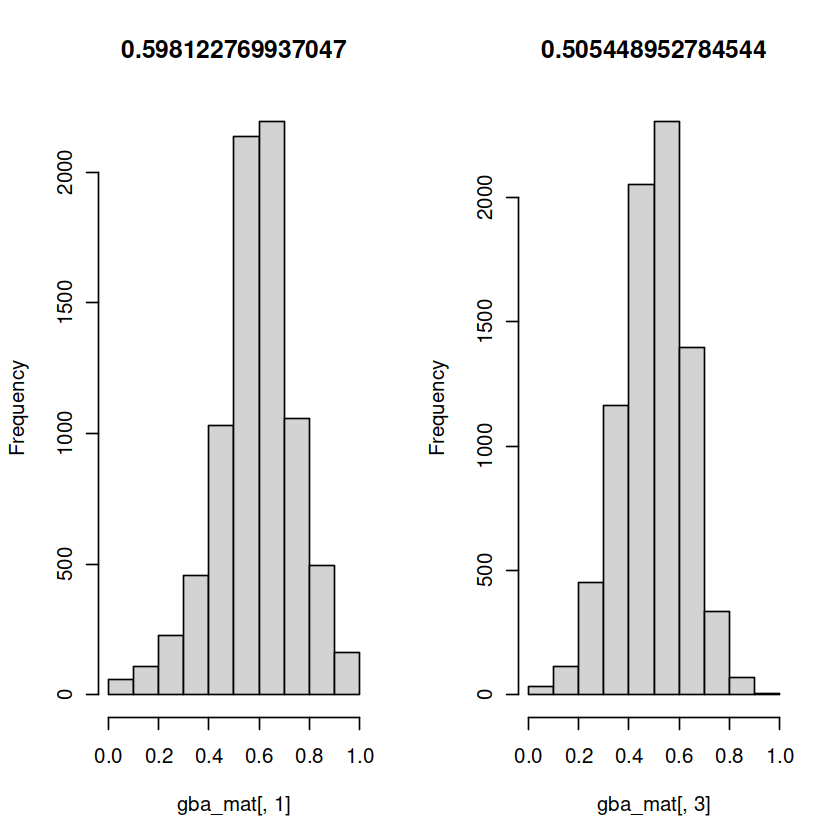

In [10]:
par(mfrow=c(1,2))
hist(gba_mat[,1], main = median(gba_mat[,1]))
hist(gba_mat[,3], main = median(gba_mat[,3]))

In [11]:
# save
df = data.frame(rownames(gba_mat), gba_mat)
colnames(df)[1] <- 'GO_term'
rownames(df) <- NULL
write.table(df, file = paste0(stage1, '_GBA.csv'), sep = ',', row.names = F, col.names = T, quote = F)

In [12]:
# plot GBA scores across stages
stages = c('stage14', 'stage17', 'stage21')
df = c()
for(ii in 1:length(stages)){
    temp = read.delim(paste0(stages[ii], '_GBA.csv'), sep = ',')
    temp$stage = stages[ii]
    df = rbind(df, temp)
}
df$stage = as.factor(df$stage)
df[1,]

GO_term    auc       avg_node_degree degree_null_auc stage  
1 GO:0000002 0.5259158 2050.56         0.3444292       stage14

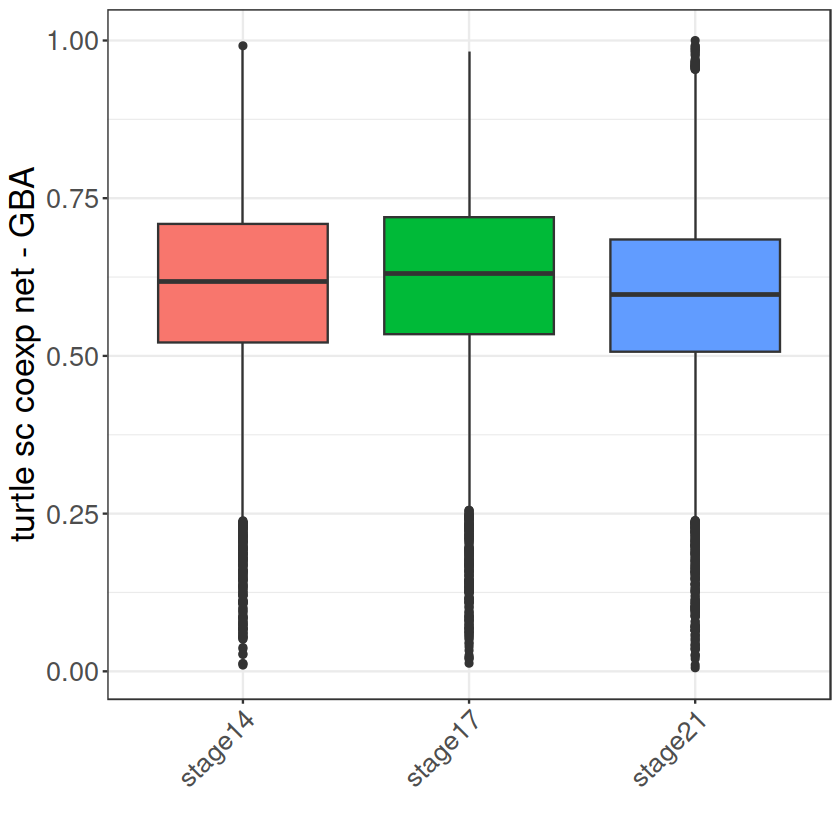

In [14]:
library(ggplot2)
library(ggridges)

# png('aaabb.png', width = 5, height = 8, res = 300, units = 'in')
ggplot(df, aes(x = stage, y = auc, fill = stage)) + geom_boxplot() + theme_bw() + 
theme(legend.position = 'none') + theme(text = element_text(size=20),
        axis.text.x = element_text(angle=45, hjust=1)) + xlab('') + ylab('turtle sc coexp net - GBA')
# dev.off()

In [18]:
library(MetaNeighbor)

In [15]:
# Qiu marker sets for main subtypes
neuron_markers = c('OTX2', 'PAX6', 'PAX2', 'PAX5', 'EOMES', 'SLC17A6', 'GAD1', 'SLC32A1', 'NEUROD1', 'SOX10')

meso_markers = c('PAX3', 'PAX7', 'PAX1', 'PAX9', 'TBX6')

hf_markers = c('TBX5', 'HCN4', 'GATA4', 'MYF5')

endo_markers = c('KDR', 'CDH5', 'PECAM1')

epi_markers = c('CDH3', 'TRP63', 'TFAP2B', 'EGFR', 'KRT5', 'KRT14')

ery_markers = c('TSPAN8', 'SNCA', 'HBB-BS', 'ABCB4', 'SLC4A1', 'KEL', 'CD36', 'GYPA', 'HBB-BH1', 'HBA-A1',
               'HBA-X', 'HBB-Y', 'ZFPM1', 'HBZ')

wbc_markers = c('MS4A4A', 'APOE', 'LYZ2', 'SELENOP', 'PTPRC', 'LY86', 'CD34')

megak_markers = c('PF4', 'ITGB3', 'ITGA2B', 'CD226')

In [30]:
# function to get top 100 markers for each cell type
library(data.table)
library(dplyr)

get_top_markers <- function(markers, ctypes){
    markers$rank = NA
    for(ii in 1:length(ctypes)){
        id = which(markers$cell_type==ctypes[ii])
        markers$rank[id] = 1:length(id)
    }
    return(markers)
}

In [31]:
# load list of orthologs
om = read.delim('mouse_turtle_orthologs_biomart.txt', sep = '\t')
colnames(om) <- c('mouse', 'turtle', 'LCA', 'homology_type', 'orthology_confidence')
om <- om[om[,1]!='' & om[,2]!='' & om$homology_type=='ortholog_one2one',]
dim(om)
om[1,]

# load class markers
markers = fread('~/septation/Qiu_major_celltype_markers_E11.5.csv.gz')
markers$gene <- om$turtle[match(markers$gene, om$mouse)]
markers <- markers[!is.na(markers$gene),]
ctypes = unique(markers$cell_type)

# get rank of markers
markers = get_top_markers(markers, ctypes)

# tibble of group, cell_type, gene, rank
top_markers = as_tibble(markers[which(markers$rank<=100),c('group', 'cell_type', 'gene')])

top_markers[1:2,]

[1] 12741     5

mouse  turtle LCA        homology_type    orthology_confidence
11 mt-Nd2 ND2    Vertebrata ortholog_one2one 1

group cell_type gene 
1 all   B_cells   CDK12
2 all   B_cells   TRMU

In [35]:
neuron_markers = top_markers$gene[(top_markers$cell_type=='Neural_crest_PNS_neurons')]
meso_markers = top_markers$gene[(top_markers$cell_type=='Mesoderm')]
hf_markers = top_markers$gene[(top_markers$cell_type=='Cardiomyocytes')]
endo_markers = top_markers$gene[(top_markers$cell_type=='Endothelium')]

epi_markers = top_markers$gene[(top_markers$cell_type=='Epithelial_cells')]
ery_markers = top_markers$gene[(top_markers$cell_type=='Primitive_erythroid')]
wbc_markers = top_markers$gene[(top_markers$cell_type=='White_blood_cells')]
megak_markers = top_markers$gene[(top_markers$cell_type=='Megakaryocytes')]       

In [36]:
ctypes = c('neuron', 'mesoderm', 'heart_field', 'endothelial', 'epithelial',
           'erythroid', 'WBCs', 'megakaryocytes')
df_markers = data.frame(marker = c(neuron_markers, meso_markers, hf_markers, endo_markers, epi_markers,
                                  ery_markers, wbc_markers, megak_markers), 
                        celltype = c(rep(ctypes[1], length(neuron_markers)), rep(ctypes[2], length(meso_markers)),
                                    rep(ctypes[3], length(hf_markers)), rep(ctypes[4], length(endo_markers)),
                                    rep(ctypes[5], length(epi_markers)), rep(ctypes[6], length(ery_markers)),
                                    rep(ctypes[7], length(wbc_markers)), rep(ctypes[8], length(megak_markers))))
colpal = c('#6872d2', '#d97710', '#97d1b0', '#a14a67', '#daca21', '#5b9946', '#820bd3', '#c504ad')

In [47]:
ctypes = c('mesoderm', 'heart_field', 'endothelial',
           'erythroid', 'megakaryocytes')
df_markers = data.frame(marker = c(meso_markers, hf_markers, endo_markers, 
                                  ery_markers, megak_markers), 
                        celltype = c(rep(ctypes[1], length(meso_markers)),
                                    rep(ctypes[2], length(hf_markers)), rep(ctypes[3], length(endo_markers)),
                                    rep(ctypes[4], length(ery_markers)), rep(ctypes[5], length(megak_markers))))
colpal = c('#6872d2', '#d97710', '#97d1b0', '#a14a67', '#daca21', '#5b9946', '#820bd3', '#c504ad')

In [54]:
stage1 = 'stage14'

file1 = paste0(stage1, '_sample_aggregate_top6000.Rdata')  
load(file1)

In [55]:
df_markers2 = df_markers
df_markers2 <- df_markers2[which(!is.na(match(df_markers$marker, rownames(aggNet)))),]

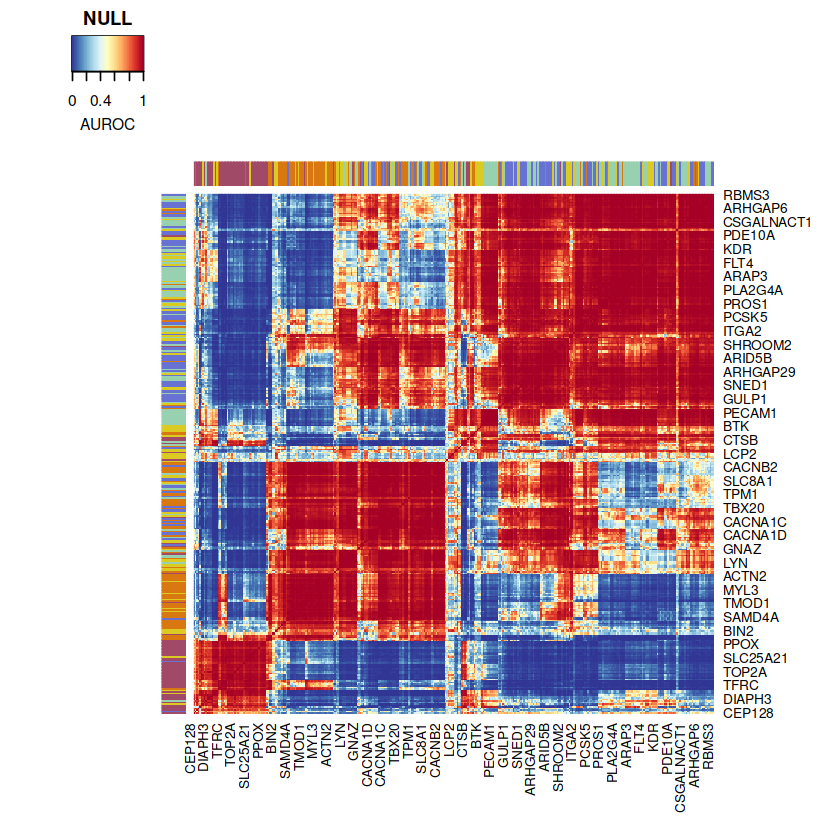

In [57]:
ColSideColors1 = colpal[match(df_markers2$celltype, ctypes)]

genes1 = df_markers2$marker
rids = match(genes1, rownames(aggNet))

# png(paste0(stage1, '_marker_hmap.png'), width = 8, height = 8, res = 300, units = 'in')
plotHeatmap(aggNet[rids,rids], dendrogram = 'none', Rowv = TRUE, Colv = TRUE, 
            ColSideColors = ColSideColors1, RowSideColors = ColSideColors1)
# dev.off()